##### Copyright 2020 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title License header
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ResNet

[ResNet](https://arxiv.org/abs/1512.03385) is a deep neural network architecture for image recognition.

This notebook

* Constructs a [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50) model using `tf.keras`, with weights pretrained using the[ImageNet](http://www.image-net.org/) database
* Saves that model using `tf.saved_model` then compiles it with IREE
* Tests TensorFlow and IREE execution of the model on a sample image

In [0]:
#@title Imports and common setup

import os
import tensorflow as tf
from matplotlib import pyplot as plt
from pyiree.tf import compiler as ireec
from pyiree import rt as ireert

SAVE_PATH = os.path.join(os.environ["HOME"], "saved_models")
os.makedirs(SAVE_PATH, exist_ok=True)

In [3]:
#@title Construct a pretrained ResNet model with ImageNet weights

tf.keras.backend.set_learning_phase(False)

# Static shape, including batch size (1).
# Can be dynamic once dynamic shape support is ready.
INPUT_SHAPE = [1, 224, 224, 3]

tf_model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet", include_top=True, input_shape=tuple(INPUT_SHAPE[1:]))

tf_module = tf.Module()
tf_module.m = tf_model
tf_module.predict = tf.function(
    input_signature=[tf.TensorSpec(INPUT_SHAPE, tf.float32)])(tf_model.call)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [4]:
#@title Export as a SavedModel.
saved_model_path = os.path.join(SAVE_PATH, "resnet.sm")
save_options = tf.saved_model.SaveOptions(save_debug_info=True)
tf.saved_model.save(tf_module, saved_model_path, options=save_options)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Scott\saved_models\resnet.sm\assets


In [0]:
#@title Compile the SavedModel to an IREE compiler module.

TARGET_BACKENDS = ("vmla",)  # others: vulkan-spirv, llvm-ir
DRIVER_NAME = "vmla"         # others: vulkan      , llvm

compiler_context = ireec.Context()
compiler_module = ireec.tf_compile_saved_model( 
    saved_model_dir=saved_model_path,
    compiler_context=compiler_context,
    exported_names=["predict"],
    target_backends=TARGET_BACKENDS)

In [6]:
#@title Register the compiler module with a runtime context.
vm_module = ireert.VmModule.from_flatbuffer(compiler_module)
rt_config = ireert.Config(DRIVER_NAME)
rt_context = ireert.SystemContext(config=rt_config)
rt_context.add_module(vm_module)

Created IREE driver vmla: <pyiree.rt.binding.HalDriver object at 0x0000024D123451F0>
SystemContext driver=<pyiree.rt.binding.HalDriver object at 0x0000024D123451F0>


Test image:


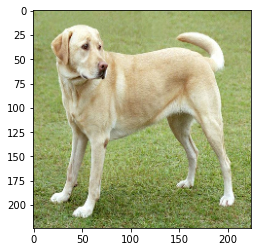

In [19]:
#@title Load a test image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)

def load_image(path_to_image):
  image = tf.io.read_file(path_to_image)
  image = tf.image.decode_image(image, channels=3)
  image = tf.image.resize(image, (224, 224))
  image = image[tf.newaxis, :]
  return image

content_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_image = load_image(content_path)

print("Test image:")
plt.imshow(content_image.numpy().reshape(224, 224, 3) / 255.0)
plt.show()

In [0]:
#@title Model pre- and post-processing
input_data = tf.keras.applications.resnet50.preprocess_input(content_image)

def decode_result(result):
  return tf.keras.applications.resnet50.decode_predictions(result, top=3)[0]

In [8]:
#@title Run TF model

print("TF prediction:")
tf_result = tf_model.predict(input_data)
print(decode_result(tf_result))

TF prediction:
[('n02091244', 'Ibizan_hound', 0.12879111), ('n02099712', 'Labrador_retriever', 0.12632939), ('n02091831', 'Saluki', 0.09625213)]


In [9]:
#@title Run IREE model

print("IREE prediction:")
iree_result = rt_context.modules.module.predict(input_data)
print(decode_result(iree_result))

IREE prediction:
[('n02091244', 'Ibizan_hound', 0.12879062), ('n02099712', 'Labrador_retriever', 0.12632969), ('n02091831', 'Saluki', 0.096252546)]
